In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

import yfinance as yf

from scipy.optimize import Bounds
from scipy.optimize import LinearConstraint
from scipy.optimize import minimize

from Data_Retriever import DataRetriever as DatRet
from Markowitz_PT import MarkowitzPT as MPT

<h1> Stock pool </h1>

In [ ]:
# Petroleum
# EQNR 36.6, AKRBP 35.3, Subsea7 17.9, Vår energi 27.9

# Food (Seafood)
# Orkla 18, Mowi 21.2, Salmar 18.7, LSG 29.2

# Materials
# NHY 15.7, Yara 25.6, NSKOG 23.1, ELK 29.9

# Technologies
# TEL 19.8, NOD 13.8, ATEA 18.1, BOUV 19

# Financials
# STB 17.2, DNB 14, GJF 17.2, MING.OL 19.5

# Shipping
# WAWI 19.7, SNI 21.2, BELCO 26.8, ODF 19.3

In [2]:
# Defining stock pool
ticker_df =  pd.DataFrame()
ticker_df["Petroleum"] = ["AKRBP.OL", "EQNR.OL", "ODL.OL"]
ticker_df["Materials"] = ["NHY.OL", "NSKOG.OL", "RANA.OL"]
ticker_df["Food"] = ["LSG.OL", "MOWI.OL", "ORK.OL"]
ticker_df

,Petroleum,Materials,Food
0,AKRBP.OL,NHY.OL,LSG.OL
1,EQNR.OL,NSKOG.OL,MOWI.OL
2,ODL.OL,RANA.OL,ORK.OL


In [3]:
# Retrieve data from yf API
data = DatRet(ticker_df, "2022-02-19", "2025-02-18")
data.retrieve_data()

# Generate benchmark weights thorugh MPT using Sharpe ratio
benchmark = MPT(data.returns, 252,10)
benchmark.frequency_optimizing()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


--Frequency trading using MPT successfully performed--


In [4]:
flat_series_list = [series for row in data.returns for series in row]
df = pd.concat(flat_series_list,axis=1)

In [5]:
df.tail(10)

Ticker,AKRBP.OL,EQNR.OL,ODL.OL,NHY.OL,NSKOG.OL,RANA.OL,LSG.OL,MOWI.OL,ORK.OL
Date,,,,,,,,,
2025-02-04,0.980482,0.983981,0.996774,0.994878,1.005080,0.987688,1.017757,0.998175,1.006816
2025-02-05,0.982857,1.042989,0.996785,1.004236,0.984988,0.993206,0.997204,1.007816,1.000975
2025-02-06,1.008230,1.013701,1.013029,0.963838,1.025663,1.004093,0.993519,1.005083,0.989392
2025-02-07,0.991837,0.994512,0.998374,1.011803,1.140488,0.985215,1.003717,1.002780,1.000000
2025-02-10,0.973381,0.969541,0.993538,1.008631,0.990338,1.001346,0.997220,0.993097,0.994247
2025-02-11,0.977096,0.968028,0.979430,1.023142,1.013712,1.008141,0.996307,0.992691,0.998086
2025-02-12,1.034123,1.043172,0.992151,0.999696,1.000000,1.008208,1.005571,1.012020,1.011617
2025-02-13,1.015077,1.048842,1.007911,0.984417,0.901943,0.979893,0.984461,0.985421,0.951197
2025-02-14,0.998779,0.997090,1.000000,1.013977,0.952061,0.984169,0.989150,0.986517,1.010233


In [12]:
daily_ben_weights

array([[0.08864726, 0.08528474, 0.05065378, 0.03385956, 0.02463224,
        0.13748145, 0.00888714, 0.28671418, 0.28383964],
       [0.08758808, 0.0851394 , 0.05111089, 0.03416971, 0.02462279,
        0.13692387, 0.00917364, 0.2864716 , 0.28480002],
       [0.09500145, 0.07830182, 0.04853153, 0.03360395, 0.02513368,
        0.13915771, 0.01029026, 0.28550516, 0.28447446],
       [0.09660061, 0.07744091, 0.04791983, 0.03457229, 0.02459559,
        0.1391249 , 0.01048997, 0.28383968, 0.28541622],
       [0.09940603, 0.07596706, 0.04646623, 0.03549567, 0.02375778,
        0.14112763, 0.01108933, 0.28099798, 0.28569228],
       [0.09696117, 0.07470732, 0.04768967, 0.03997647, 0.02318618,
        0.14059603, 0.01619748, 0.27639633, 0.28428935],
       [0.08157242, 0.09407492, 0.0475911 , 0.04429612, 0.02233795,
        0.13659367, 0.01545903, 0.27701294, 0.28106185],
       [0.07793016, 0.09122488, 0.04763484, 0.0444199 , 0.01390184,
        0.12565151, 0.0149832 , 0.25908158, 0.32517208],


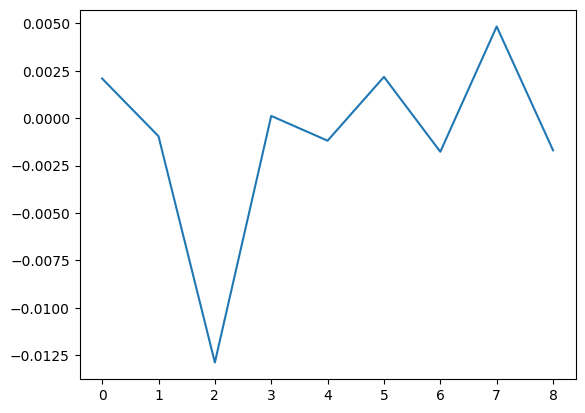

In [11]:
daily_returns = []
for time in range(1,10,1):
    ind_day_ret = np.array([data.returns[i][j].iloc[-time].iloc[0] for i in  range(3) for j in range(3)]) -1
    daily_returns.append(ind_day_ret[::])
daily_returns = daily_returns[::-1]

daily_ben_weights = benchmark.frequency_weights[:-1]
daily_ben_weights = np.array([np.array(benchmark.frequency_weights[i][0]) for i in range(len(benchmark.frequency_weights))])[:-1]
daily_exp_weights = np.repeat(1/9,9)


# rl_perf = [daily_ben_weights[time]@daily_returns[time] for time in range(9)]
rl_perf = [sum(daily_ben_weights[time]*daily_returns[time]) for time in range(9)]

# mpt_perf = [daily_exp_weights@daily_returns[time] for time in range(9)]
mpt_perf = [sum(daily_exp_weights*daily_returns[time]) for time in range(9)]

# excess_ret = [(rl_perf[time]-mpt_perf[time])/rl_perf[time] for time in range(9)]
excess_ret = [rl_perf[time] - mpt_perf[time] for time in range(9)]

plt.plot(excess_ret)

In [42]:
bitch = []
for i in range(0, 9, 1):
    bitch.append(daily_exp_weights)

In [44]:
daily_exp_weights = bitch

In [ ]:
def bhb_attribution(daily_returns, daily_ben_weights, daily_exp_weights):
    """
    Calculates the Brinson, Hood, and Beebower (BHB) attribution effects: allocation, selection, and interaction.
    
    Parameters:
    - daily_returns: list of np.arrays, each of shape (9,), daily returns for 9 stocks.
    - daily_ben_weights: list of np.arrays, each of shape (9,), benchmark weights for 9 stocks.
    - daily_exp_weights: list of np.arrays, each of shape (9,), portfolio weights for 9 stocks.
    
    Returns:
    - allocation_effect: np.array of shape (time, 3), allocation effect per sector.
    - selection_effect: np.array of shape (time, 3), selection effect per sector.
    - interaction_effect: np.array of shape (time, 3), interaction effect per sector.
    - total_excess_return: np.array of shape (time,), total excess return per day.
    """
    num_sectors = 3
    stocks_per_sector = 3
    
    # Convert lists to NumPy arrays
    daily_returns = np.array(daily_returns)
    daily_ben_weights = np.array(daily_ben_weights)
    daily_exp_weights = np.array(daily_exp_weights)
    
    # Initialize effect arrays
    allocation_effect = np.zeros((daily_returns.shape[0], num_sectors))
    selection_effect = np.zeros((daily_returns.shape[0], num_sectors))
    interaction_effect = np.zeros((daily_returns.shape[0], num_sectors))
    
    # Compute attribution effects per sector
    for i in range(num_sectors):
        wb = np.sum(daily_ben_weights[:, i*stocks_per_sector:(i+1)*stocks_per_sector], axis=1)
        we = np.sum(daily_exp_weights[:, i*stocks_per_sector:(i+1)*stocks_per_sector], axis=1)
        rb = np.sum(daily_ben_weights[:, i*stocks_per_sector:(i+1)*stocks_per_sector] * daily_returns[:, i*stocks_per_sector:(i+1)*stocks_per_sector], axis=1)
        re = np.sum(daily_exp_weights[:, i*stocks_per_sector:(i+1)*stocks_per_sector] * daily_returns[:, i*stocks_per_sector:(i+1)*stocks_per_sector], axis=1)
        
        allocation_effect[:, i] = rb * (we - wb)
        selection_effect[:, i] = wb * (re - rb)
        interaction_effect[:, i] = (we - wb) * (re - rb)
    
    total_excess_return = np.sum(allocation_effect + selection_effect + interaction_effect, axis=1)
    
    return allocation_effect, selection_effect, interaction_effect, total_excess_return


In [46]:
rix = bhb_attribution(daily_returns, daily_ben_weights, daily_exp_weights)

In [47]:
rix

(array([[ 2.15725187e-04, -1.59384791e-04, -6.13489113e-04],
        [ 2.79578696e-04, -5.96670846e-06,  4.01380070e-04],
        [-1.43183869e-04,  2.53289614e-04, -2.05466484e-04],
        [-5.83569436e-04,  3.34902738e-05,  8.94576797e-04],
        [-6.31205936e-04,  3.05282499e-04,  6.45731328e-04],
        [ 7.02033408e-04,  1.47951632e-04, -1.63545923e-03],
        [ 6.82724855e-04, -7.32125102e-04,  4.32248279e-03],
        [-4.20316677e-05, -3.03915322e-04,  8.73431180e-05],
        [ 2.08035962e-04, -1.35249813e-04, -1.13193642e-04]]),
 array([[ 1.19197993e-04, -1.55186631e-04, -1.05845454e-03],
        [ 2.97976304e-04, -1.30830193e-04,  1.68509678e-04],
        [-9.16905020e-05,  2.65343180e-03, -6.38753017e-05],
        [-4.04003535e-04, -4.22364948e-05,  1.11038242e-03],
        [-6.03717687e-04,  5.41700382e-04,  6.97055154e-04],
        [ 3.41464128e-04, -5.37227811e-05, -2.00164303e-03],
        [ 3.97361102e-04, -1.87651808e-03,  5.29161306e-03],
        [-2.13301763e-

In [ ]:
def calculate_bhb(daily_ben_weights, daily_returns, daily_exp_weights):
    """
    Calculate Brinson, Hood, and Beebower (BHB) attribution model.

    Args:
        daily_ben_weights (list): List of 9 benchmark weights.
        daily_returns (list): List of 9 daily returns.
        daily_exp_weights (list): List of 9 experimental portfolio weights.

    Returns:
        tuple: Allocation effect, selection effect, interaction effect, and total excess return.
    """
    allocation_effect = 0
    selection_effect = 0
    interaction_effect = 0
    
    # Divide portfolio into 3 sectors (0:3, 3:6, 6:9)
    for i in range(3):
        wb = sum(daily_ben_weights[0][i*3:(i+1)*3])
        we = sum(daily_exp_weights[i*3:(i+1)*3])
        rb = sum(np.array(daily_ben_weights[0][i*3:(i+1)*3]) * np.array(daily_returns[0][i*3:(i+1)*3]))
        re = sum(np.array(daily_exp_weights[i*3:(i+1)*3]) * np.array(daily_returns[0][i*3:(i+1)*3]))
        
        allocation_effect += rb * (we - wb)  # Allocation Effect
        selection_effect += wb * (re - rb)  # Selection Effect
        interaction_effect += (we - wb) * (re - rb)  # Interaction Effect
    
    total_excess_return = allocation_effect + selection_effect + interaction_effect
    
    return allocation_effect, selection_effect, interaction_effect, total_excess_return


In [95]:
fox = calculate_bhb(daily_ben_weights,daily_returns, daily_exp_weights)

In [96]:
fox

(np.float64(-0.0005328568492038127),
 np.float64(-0.0011743012428612075),
 np.float64(0.00036851326751202317),
 np.float64(-0.001338644824552997))

In [97]:
sum(fox[:3])

np.float64(-0.001338644824552997)

In [98]:
wb1 = np.sum(daily_ben_weights[0][:3])
we1 = np.sum(daily_exp_weights[:3])
rb1 = np.dot(daily_ben_weights[0][:3], daily_returns[0][:3])
re1 = np.dot(daily_exp_weights[:3], daily_returns[0][:3])

wb2 = np.sum(daily_ben_weights[0][3:6])
we2 = np.sum(daily_exp_weights[3:6])
rb2 = np.dot(daily_ben_weights[0][:3], daily_returns[0][3:6])
re2 = np.dot(daily_exp_weights[:3], daily_returns[0][3:6])


wb3 = np.sum(daily_ben_weights[0][6:9])
we3 = np.sum(daily_exp_weights[6:9])
rb3 = np.dot(daily_ben_weights[0][:3], daily_returns[0][6:9])
re3 = np.dot(daily_exp_weights[:3], daily_returns[0][6:9])

# Allocations:
ae1 = rb1*(we1-wb1)
ae2 = rb2*(we2-wb2)
ae3 = rb3*(we3-wb3)
allocation = ae1+ae2+ae3

# Selections:
se1 = wb1*(re1-rb1)
se2 = wb2*(re2-rb2)
se3 = wb3*(re3-rb3)
selection = se1+se2+se3

# Interaction:
ie1 = (we1-wb1)*(re1-rb1)
ie2 = (we2-wb2)*(re2-rb2)
ie3 = (we3-wb3)*(re3-rb3)
interaction = ie1 + ie2+ ie3

print(allocation*100)
print(selection*100)
print(interaction*100)
delta=allocation+selection+interaction
print(delta)

-0.006934288266357137
0.0015404291477781572
-0.009500069902821807
-0.00014893929021400786


In [99]:
fox

(np.float64(-0.0005328568492038127),
 np.float64(-0.0011743012428612075),
 np.float64(0.00036851326751202317),
 np.float64(-0.001338644824552997))

In [100]:
print(delta-1)
print(excess_ret[0]+1)

-1.000148939290214
1.0024173639260476


In [101]:
# class BHBAnalyzer():
    
#     def __init__(self, 
#                  benchmark_data=None,
#                  experiment_data=None,
#                  raw_data=None
#                  ):
#         """
#         Args:
#             benchmark_data: NxM list from MPT
#             experiment_data: NxM list from RL    
#         """
#         self.benchmark_data =  benchmark_data
#         self.experiment_data = experiment_data
#         self.raw_data = raw_data

#     def frequency_analyze():
#         pass